In [66]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

sns_c = sns.color_palette(palette='deep')


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, ConstantKernel, DotProduct
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

import warnings

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)



from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


In [26]:
df = pd.read_csv('Data/lag_features.csv').drop('Unnamed: 0', axis = 1)
df

,Data,cum_casos,target,media_movel,t
0,2020-01-22,0.009,0.001,0.006000,8
1,2020-01-31,0.010,0.003,0.007000,9
2,2020-02-01,0.011,0.004,0.008000,10
3,2020-02-03,0.012,0.005,0.009000,11
4,2020-02-09,0.013,0.006,0.010000,12
...,...,...,...,...,...
460,2021-06-27,26.542,26.229,26.445857,468
461,2021-06-28,26.580,26.323,26.482571,469
462,2021-06-29,26.600,26.371,26.515286,470
463,2021-06-30,26.633,26.419,26.545857,471


In [27]:
X = np.array(df[['t', 'cum_casos', 'media_movel']])
y = np.array(df['target']).reshape(-1,1)


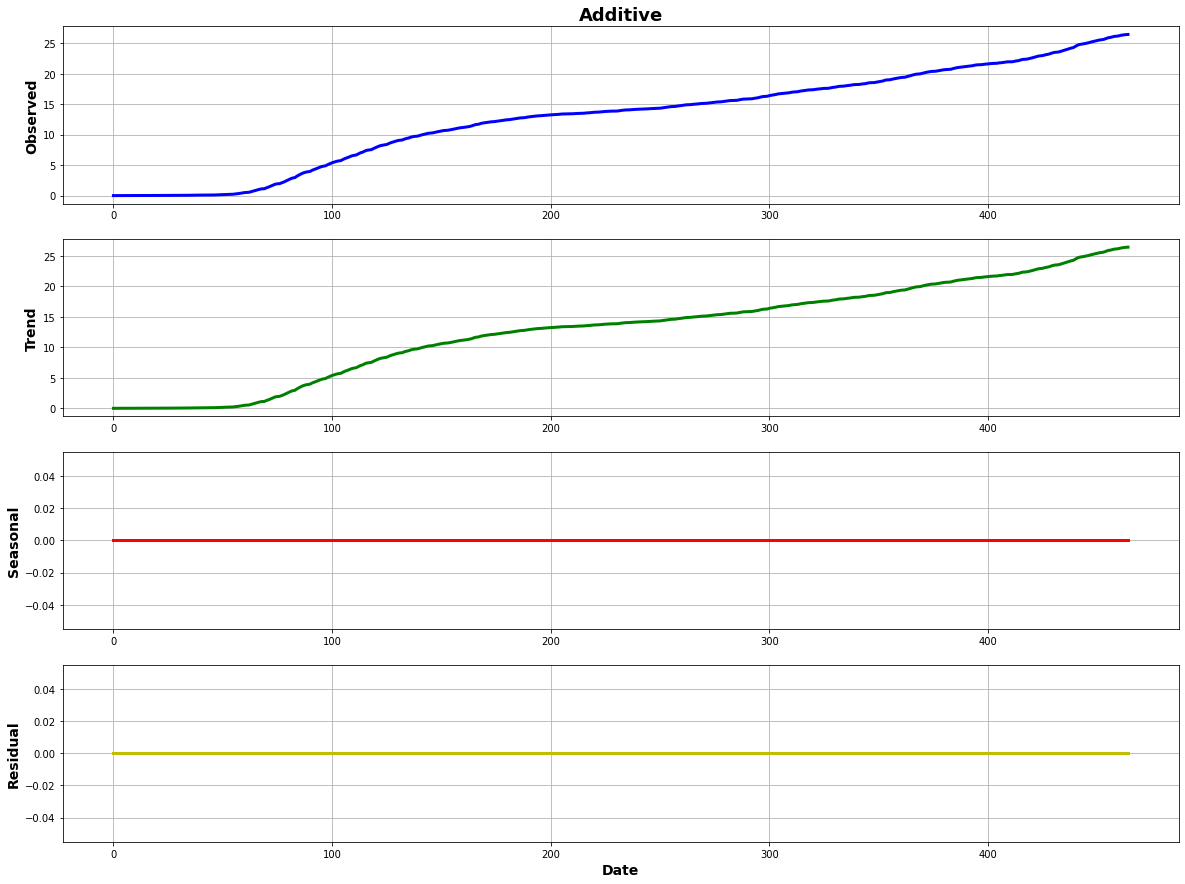

In [28]:
ts = df['target']

# Decomposing using seasonal_decompose

result_add = seasonal_decompose(ts, model='additive', extrapolate_trend='freq', period = 1)
#result_mult = seasonal_decompose(ts, model='multiplicative', extrapolate_trend='freq', period = 1)

# Plot
fig, axs = plt.subplots(figsize = (20,15), nrows = 4, ncols = 1)


axs[0].plot(result_add.observed, linewidth = 3, color = 'b')
axs[0].set_ylabel('Observed', fontsize = 14, fontweight = 'bold')
axs[0].set_title('Additive', fontsize = 18, fontweight = 'bold')
axs[0].grid(True)


axs[1].plot(result_add.trend,linewidth = 3, color = 'g')
axs[1].set_ylabel('Trend', fontsize = 14, fontweight = 'bold')
axs[1].grid(True)

axs[2].plot(result_add.seasonal,linewidth = 3, color = 'r')
axs[2].set_ylabel('Seasonal', fontsize = 14, fontweight = 'bold')
axs[2].grid(True)

axs[3].plot(result_add.resid,linewidth = 3, color = 'y')
axs[3].set_ylabel('Residual', fontsize = 14, fontweight = 'bold')
axs[3].set_xlabel('Date', fontsize = 14, fontweight = 'bold')
axs[3].grid(True)


plt.show()


# Primeira tentativa de modelagem: Definição de kernels de maneira intuitiva

A partir da decomposição da série, podemos notar que trata-se de um dado apenas com tendência. Dessa forma, podemos supor que combinações de kernel RBF e DotProduct possam capturar bem o dado. Assim, definiremos algumas combinações de kernels variando os parâmetros:

De acordo com a referência, existem estruturas de kernels formadas a partir de soma e multiplicação adequada para cada tipo de problema. Para regressão polinomial, podemos utilizar um kernel do tipo: C + prod(Lin) + WN. Já para um problema de regressão semi-parametrica, podemos utilizar um kernel do tipo: Lin + SE + WN. Vamos testar essas duas abordagens, definindo um espaço de busca e percorre-lo encontrando o melhor kernel.

## Regressão polinomial

* Kernel constante: Variação do valor entre x e y
* prod(Lin): Testar polinômios de grau 1 até grau 6
* WN: Variar valores entre a e b

## Método semi-paramétrico

* Linear: testar polinômios de grau 1 até grau 6, multiplicar por constante
* SE: Testar diferentes valores do lenghtscale
* WN:> variar valores entre a e b

## Método polinomial

In [29]:
# Regressão polinomial

reg_pol_kernels = []
## Constant -- Não estacionário
constant_kernels = [ConstantKernel(constant_value=x) for x in range(1,5)]

## Linear -- Não estacionário
linear_kernels = [DotProduct()**exponent for exponent in range(1,7)]

noise_kernels = [WhiteKernel()]

for ck in constant_kernels:
    for lk in linear_kernels:
        for nk in noise_kernels:
            reg_pol_kernels.append(ck + lk + nk)


In [30]:
tscv = TimeSeriesSplit(n_splits=10)
model = GaussianProcessRegressor()
param_search = {'model__kernel': reg_pol_kernels, 'model__alpha': [1e-2, 1e-3]}

training_pipeline = Pipeline([('model', model)])

scoring = {'R2': 'r2', 'mse': 'neg_root_mean_squared_error', 'mae': 'neg_mean_absolute_error', 'mape': 'neg_mean_absolute_percentage_error'}


gsearch = GridSearchCV(estimator=training_pipeline, cv=tscv, scoring=scoring,
                        param_grid=param_search, refit = 'R2')

In [31]:
# Fit dos dados
gsearch.fit(X,y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('model', GaussianProcessRegressor())]),
             param_grid={'model__alpha': [0.01, 0.001],
                         'model__kernel': [1**2 + DotProduct(sigma_0=1) ** 1 + WhiteKernel(noise_level=1),
                                           1**2 + DotProduct(sigma_0=1) ** 2 + WhiteKernel(noise_level=1),
                                           1**2 + DotProduct(sigma_0=1) **...
                                           2**2 + DotProduct(sigma_0=1) ** 3 + WhiteKernel(noise_level=1),
                                           2**2 + DotProduct(sigma_0=1) ** 4 + WhiteKernel(noise_level=1),
                                           2**2 + DotProduct(sigma_0=1) ** 5 + WhiteKernel(noise_level=1),
                                           2**2 + DotProduct(sigma_0=1) ** 6 + WhiteKernel(noise_level=1)]},
             refit='R2',
             scoring={'R2':

In [32]:
results = pd.DataFrame(gsearch.cv_results_)
results = results.sort_values(by='rank_test_R2')
results.reset_index(inplace= True, drop = True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__kernel,params,split0_test_R2,split1_test_R2,split2_test_R2,...,split3_test_mape,split4_test_mape,split5_test_mape,split6_test_mape,split7_test_mape,split8_test_mape,split9_test_mape,mean_test_mape,std_test_mape,rank_test_mape
0,0.509698,0.412407,0.004425,0.005070,0.001,1.41**2 + DotProduct(sigma_0=1) ** 1 + WhiteKe...,"{'model__alpha': 0.001, 'model__kernel': 1.41*...",0.965810,0.925116,0.975046,...,-0.004668,-0.002001,-0.002640,-0.002363,-0.002625,-0.001923,-0.002332,-0.024021,0.045344,3
1,0.665272,0.958870,0.003621,0.004945,0.001,2**2 + DotProduct(sigma_0=1) ** 1 + WhiteKerne...,"{'model__alpha': 0.001, 'model__kernel': 2**2 ...",0.965809,0.925116,0.975045,...,-0.004668,-0.002001,-0.002640,-0.002363,-0.002625,-0.001923,-0.002332,-0.024021,0.045344,1
2,0.857959,0.957769,0.005128,0.005196,0.001,1**2 + DotProduct(sigma_0=1) ** 1 + WhiteKerne...,"{'model__alpha': 0.001, 'model__kernel': 1**2 ...",0.965810,0.925116,0.975045,...,-0.004668,-0.002001,-0.002640,-0.002363,-0.002625,-0.001923,-0.002332,-0.024021,0.045344,4
3,0.861884,0.817688,0.004090,0.005317,0.001,1.73**2 + DotProduct(sigma_0=1) ** 1 + WhiteKe...,"{'model__alpha': 0.001, 'model__kernel': 1.73*...",0.965809,0.925116,0.975045,...,-0.004668,-0.002001,-0.002640,-0.002363,-0.002625,-0.001923,-0.002332,-0.024021,0.045344,2
4,0.617300,0.673120,0.002846,0.002011,0.01,1**2 + DotProduct(sigma_0=1) ** 1 + WhiteKerne...,"{'model__alpha': 0.01, 'model__kernel': 1**2 +...",0.750894,0.918386,0.975733,...,-0.004784,-0.002233,-0.002585,-0.002314,-0.002608,-0.001916,-0.002324,-0.026726,0.052356,5


# Métricas de avaliação dos modelos obtidos

In [33]:
# Obtendo as métricas de avaliação

r2_results = {}
splits = [0,1,2,3,4,5,6,7,8,9]
for j in range(4):
    r2_values = list(results.loc[j,[f'split{i}_test_R2' for i in range(10)]].values)
    #model_name = models_names[j]
    model_name = str(results.loc[j,'param_model__kernel'])
    r2_results[model_name] = r2_values

mae_results = {}
for j in range(4):
    mae_values = list(results.loc[j,[f'split{i}_test_mae' for i in range(10)]].values)
    mae_values = [-1*value for value in mae_values]
    #model_name = models_names[j]
    model_name = str(results.loc[j,'param_model__kernel'])
    mae_results[model_name] = mae_values

mse_results = {}
for j in range(4):
    mse_values = list(results.loc[j,[f'split{i}_test_mse' for i in range(10)]].values)
    mse_values = [-1*value for value in mse_values]
    #model_name = models_names[j]
    model_name = str(results.loc[j,'param_model__kernel'])
    mse_results[model_name] = mse_values

mape_results = {}
for j in range(4):
    mape_values = list(results.loc[j,[f'split{i}_test_mape' for i in range(10)]].values)
    mape_values = [-1*value for value in mape_values]
    #model_name = models_names[j]

    model_name = str(results.loc[j,'param_model__kernel'])
    mape_results[model_name] = mape_values

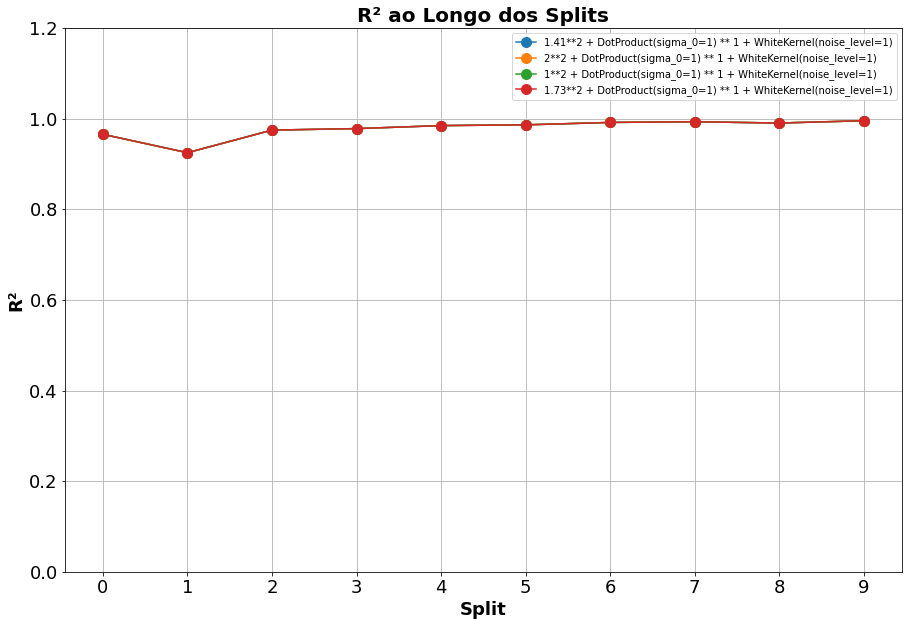

In [34]:
# Gráfico da evolução das métricas - r²
fig, ax = plt.subplots(figsize = (15,10))
for resultado in r2_results:
    ax.plot(splits,r2_results[resultado], marker = '.', markersize = 20, label = resultado)

plt.xticks(splits)  

ax.set_title('R² ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('R²', fontweight = 'bold', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid()

ax.set_ylim([0, 1.2])
ax.legend()


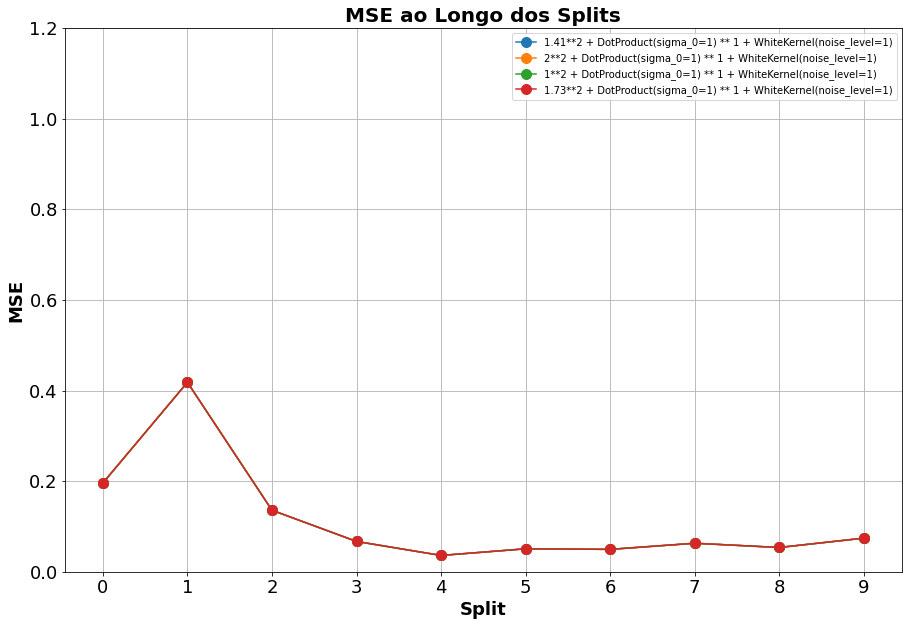

In [35]:
# Gráfico da evolução das métricas - mse
fig, ax = plt.subplots(figsize = (15,10))
for resultado in mse_results:
    ax.plot(splits,mse_results[resultado], marker = '.', markersize = 20, label = resultado)

plt.xticks(splits)  

ax.set_title('MSE ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('MSE', fontweight = 'bold', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid()

ax.set_ylim([0, 1.2])
ax.legend()


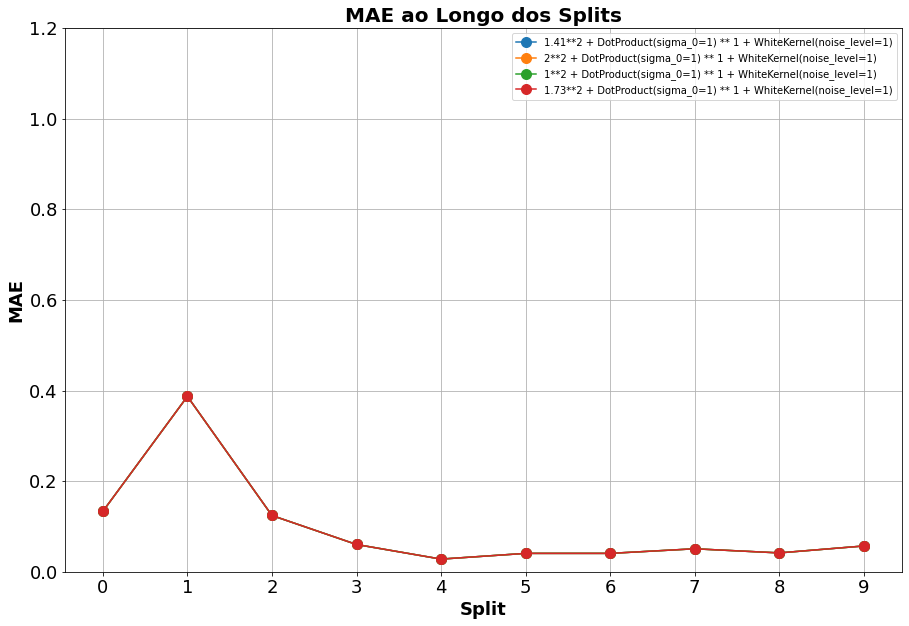

In [36]:
# Gráfico da evolução das métricas - mae
fig, ax = plt.subplots(figsize = (15,10))
for resultado in mae_results:
    ax.plot(splits,mae_results[resultado], marker = '.', markersize = 20, label = resultado)

plt.xticks(splits)  

ax.set_title('MAE ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('MAE', fontweight = 'bold', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid()

ax.set_ylim([0, 1.2])
ax.legend()


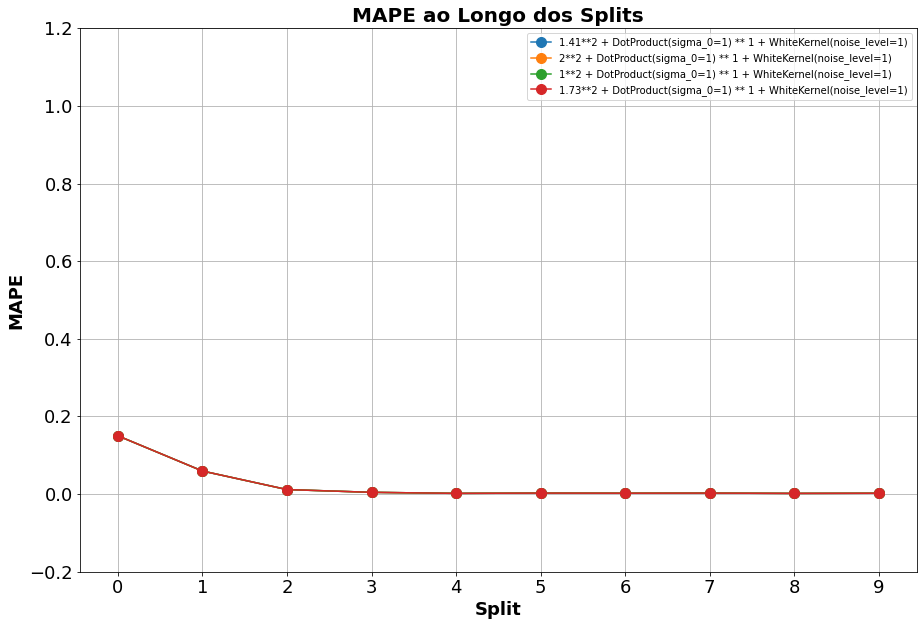

In [37]:
# Gráfico da evolução das métricas - mape
fig, ax = plt.subplots(figsize = (15,10))
for resultado in mape_results:
    ax.plot(splits,mape_results[resultado], marker = '.', markersize = 20, label = resultado)

plt.xticks(splits)  

ax.set_title('MAPE ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('MAPE', fontweight = 'bold', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid()
ax.set_ylim([-0.2, 1.2])
ax.legend()


## Visualização das predições do melhor modelo obtido

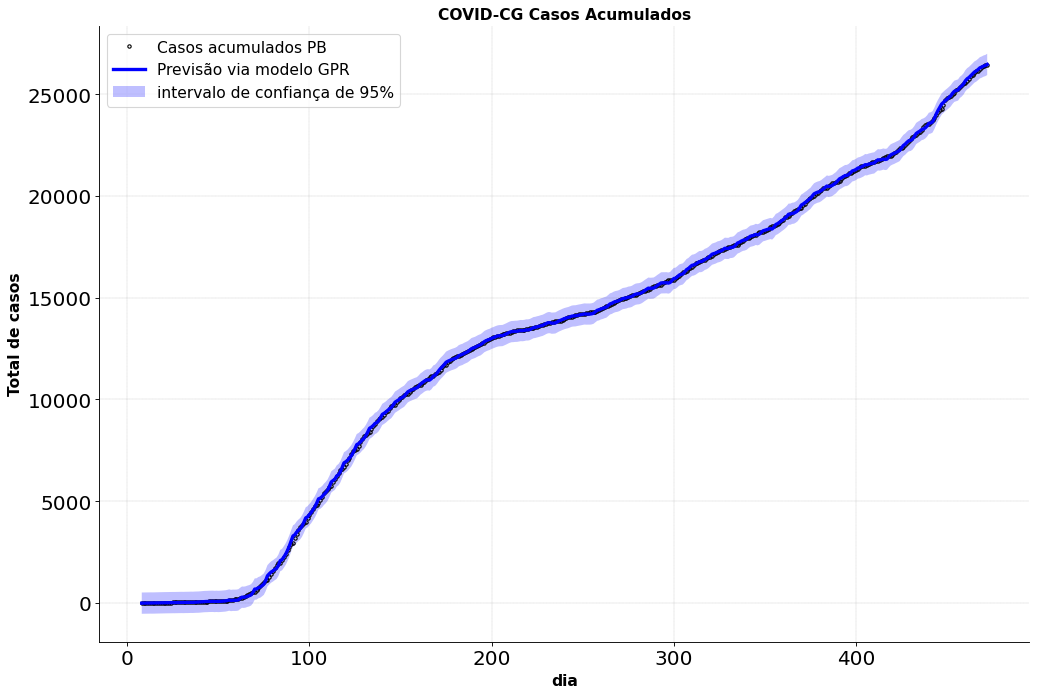

In [86]:
best_model = gsearch.best_estimator_
#Previsões do modelo

CRpred, sigma   = best_model.predict(X, return_std=True)    # previsão para todo o intervalo de dados
CRpred = np.ravel(CRpred)

# Obtendo a variável temporal
t = np.array(df['t'])
t = t.reshape(-1,1)

# Plotando as previsões do melhor modelo

plt.figure(1, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
mpl.style.use('default')
plt.plot(t, y*1000, 'ko', markersize=3, mfc='none', linewidth=1, label=r'Casos acumulados PB')
plt.plot(t, CRpred*1000, 'b-', label='Previsão via modelo GPR', linewidth = 3)


plt.fill(np.concatenate([t, t[::-1]]),
        np.concatenate([CRpred*1000 - 1.9600 * 5000*sigma,
                        (CRpred*1000 + 1.9600 * 5000*sigma)[::-1]]),
        alpha=.25, fc='b', ec='None', label='intervalo de confiança de 95%')
plt.legend(loc='upper left', fontsize = 14)
#plt.ylim(0, 100e3)
#plt.xlim(1, np.size(t) + 20)
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Total de casos', fontsize = 14, fontweight = 'bold')
plt.xlabel('dia', fontsize = 14, fontweight = 'bold')
plt.title('COVID-CG Casos Acumulados', fontsize = 14, fontweight = 'bold')
plt.tick_params(axis='both', which='major', labelsize=18)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


## Visualização da distribuição dos erros do melhor modelo obtido

/home/andre/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


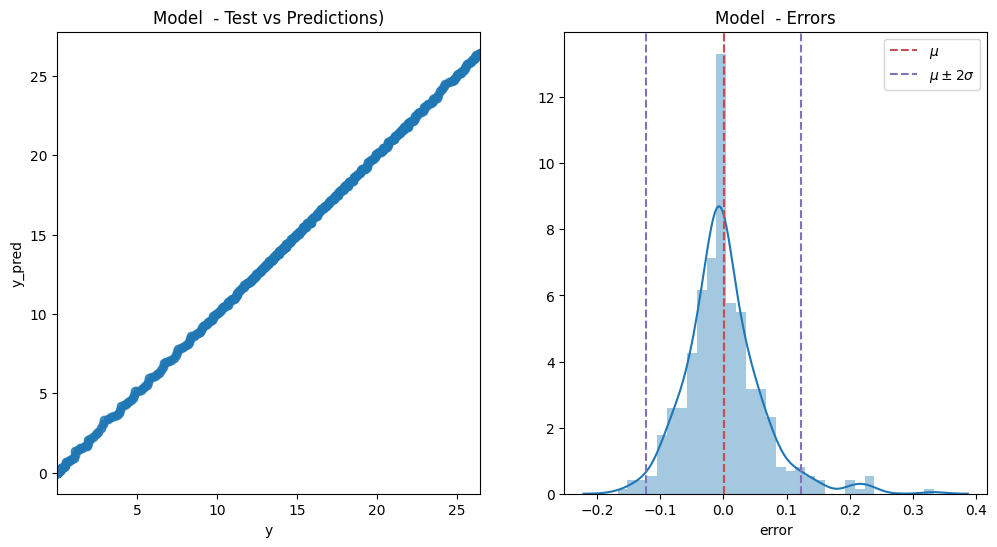

In [88]:
errors = best_model.predict(X) - y
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y.flatten(), y=best_model.predict(X).flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Model  - Test vs Predictions)', xlabel='y', ylabel='y_pred');
ax[1].set(title='Model  - Errors', xlabel='error', ylabel=None);

## Metodo semi paramétrico

In [82]:
# Regressão polinomial

semi_parametric_kernels = []

## Linear -- Não estacionário
linear_kernels = [DotProduct(sigma_0) for sigma_0 in range(1,10)]

#squared exponential

sqr_exp_kernels = [RBF(l) for l in np.logspace(-1, 1, 5)]

noise_kernels = [WhiteKernel()]

for lk in linear_kernels:
    for sek in sqr_exp_kernels:
        for nk in noise_kernels:
            semi_parametric_kernels.append(lk + sek + nk)

In [84]:
tscv = TimeSeriesSplit(n_splits=10)
model = GaussianProcessRegressor()
param_search = {'model__kernel': semi_parametric_kernels, 'model__alpha': [1e-2, 1e-3]}

training_pipeline = Pipeline([('model', model)])

scoring = {'R2': 'r2', 'mse': 'neg_root_mean_squared_error', 'mae': 'neg_mean_absolute_error', 'mape': 'neg_mean_absolute_percentage_error'}


gsearch = GridSearchCV(estimator=training_pipeline, cv=tscv, scoring=scoring,
                        param_grid=param_search, refit = False)

In [85]:
# Fit dos dados
gsearch.fit(X,y)  

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('model', GaussianProcessRegressor())]),
             param_grid={'model__alpha': [0.01, 0.001],
                         'model__kernel': [DotProduct(sigma_0=1) + RBF(length_scale=0.1) + WhiteKernel(noise_level=1),
                                           DotProduct(sigma_0=1) + RBF(length_scale=0.316) + WhiteKernel(noise_level=1...
                                           DotProduct(sigma_0=6) + RBF(length_scale=1) + WhiteKernel(noise_level=1),
                                           DotProduct(sigma_0=6) + RBF(length_scale=3.16) + WhiteKernel(noise_level=1),
                                           DotProduct(sigma_0=6) + RBF(length_scale=10) + WhiteKernel(noise_level=1), ...]},
             refit=False,
             scoring={'R2': 'r2', 'mae': 'neg_mean_absolute_error',
                      'mape': 'neg_mean_absolute_percentage_error',
         

In [86]:
results = pd.DataFrame(gsearch.cv_results_)
results = results.sort_values(by='rank_test_R2')
results.reset_index(inplace= True, drop = True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__kernel,params,split0_test_R2,split1_test_R2,split2_test_R2,...,split3_test_mape,split4_test_mape,split5_test_mape,split6_test_mape,split7_test_mape,split8_test_mape,split9_test_mape,mean_test_mape,std_test_mape,rank_test_mape
0,0.798426,1.006535,0.002256,0.000665,0.001,DotProduct(sigma_0=4) + RBF(length_scale=1) + ...,"{'model__alpha': 0.001, 'model__kernel': DotPr...",0.841371,0.923667,0.97225,...,-0.004648,-0.001924,-0.003708,-0.002396,-0.002634,-0.001928,-0.002335,-0.024899,0.047130,1
1,1.240949,1.860726,0.004012,0.004108,0.001,DotProduct(sigma_0=7) + RBF(length_scale=0.316...,"{'model__alpha': 0.001, 'model__kernel': DotPr...",0.841373,0.887700,0.97225,...,-0.004648,-0.001924,-0.002688,-0.002396,-0.002634,-0.001928,-0.009824,-0.026816,0.047952,2
2,1.528425,2.858736,0.013337,0.026671,0.001,DotProduct(sigma_0=5) + RBF(length_scale=0.316...,"{'model__alpha': 0.001, 'model__kernel': DotPr...",0.841373,0.887700,0.97225,...,-0.004648,-0.001924,-0.002688,-0.002396,-0.002634,-0.001928,-0.009824,-0.026816,0.047952,3
3,0.761946,0.988810,0.003635,0.003792,0.001,DotProduct(sigma_0=2) + RBF(length_scale=0.316...,"{'model__alpha': 0.001, 'model__kernel': DotPr...",0.841373,0.887700,0.97225,...,-0.004648,-0.001924,-0.002688,-0.002396,-0.002634,-0.001928,-0.009824,-0.026816,0.047952,4
4,0.523751,0.420598,0.004684,0.003471,0.001,DotProduct(sigma_0=3) + RBF(length_scale=0.316...,"{'model__alpha': 0.001, 'model__kernel': DotPr...",0.841373,0.887699,0.97225,...,-0.004648,-0.001924,-0.002688,-0.002396,-0.002634,-0.001928,-0.009824,-0.026816,0.047952,5


In [87]:
# Obtendo as métricas de avaliação

r2_results = {}
splits = [0,1,2,3,4,5,6,7,8,9]
for j in range(4):
    r2_values = list(results.loc[j,[f'split{i}_test_R2' for i in range(10)]].values)
    #model_name = models_names[j]
    model_name = str(results.loc[j,'param_model__kernel'])
    r2_results[model_name] = r2_values

mae_results = {}
for j in range(4):
    mae_values = list(results.loc[j,[f'split{i}_test_mae' for i in range(10)]].values)
    mae_values = [-1*value for value in mae_values]
    #model_name = models_names[j]
    model_name = str(results.loc[j,'param_model__kernel'])
    mae_results[model_name] = mae_values

mse_results = {}
for j in range(4):
    mse_values = list(results.loc[j,[f'split{i}_test_mse' for i in range(10)]].values)
    mse_values = [-1*value for value in mse_values]
    #model_name = models_names[j]
    model_name = str(results.loc[j,'param_model__kernel'])
    mse_results[model_name] = mse_values

mape_results = {}
for j in range(4):
    mape_values = list(results.loc[j,[f'split{i}_test_mape' for i in range(10)]].values)
    mape_values = [-1*value for value in mape_values]
    #model_name = models_names[j]

    model_name = str(results.loc[j,'param_model__kernel'])
    mape_results[model_name] = mape_values 
   

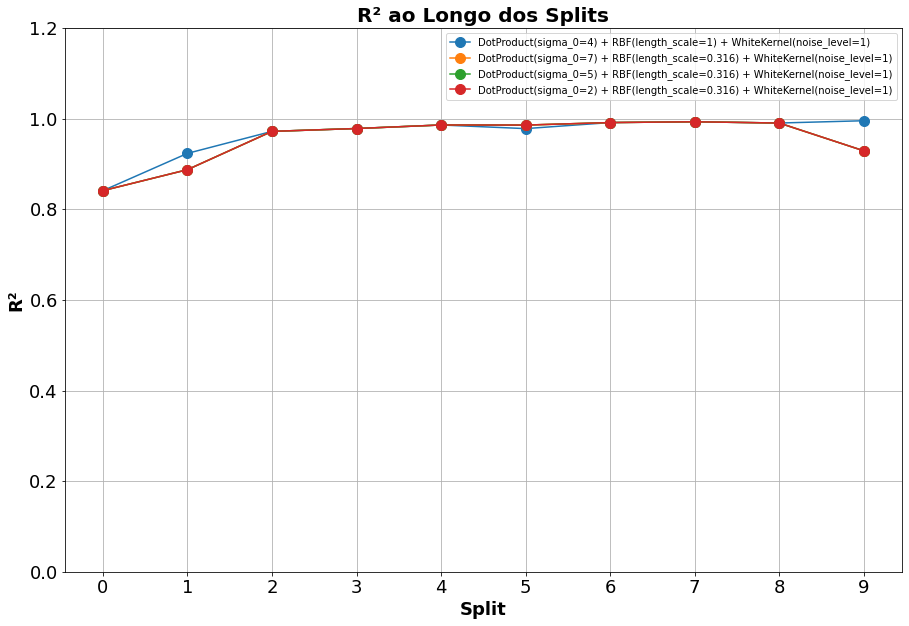

In [88]:
# Gráfico da evolução das métricas - r²
fig, ax = plt.subplots(figsize = (15,10))
for resultado in r2_results:
    ax.plot(splits,r2_results[resultado], marker = '.', markersize = 20, label = resultado)

plt.xticks(splits)  

ax.set_title('R² ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('R²', fontweight = 'bold', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid()

ax.set_ylim([0, 1.2])
ax.legend()

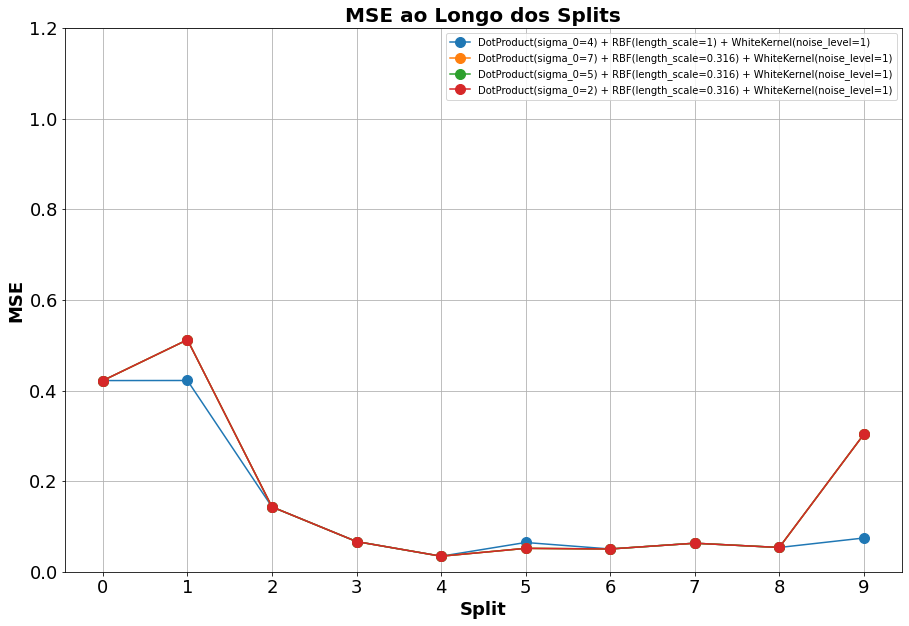

In [89]:
# Gráfico da evolução das métricas - mse
fig, ax = plt.subplots(figsize = (15,10))
for resultado in mse_results:
    ax.plot(splits,mse_results[resultado], marker = '.', markersize = 20, label = resultado)

plt.xticks(splits)  

ax.set_title('MSE ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('MSE', fontweight = 'bold', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid()

ax.set_ylim([0, 1.2])
ax.legend()

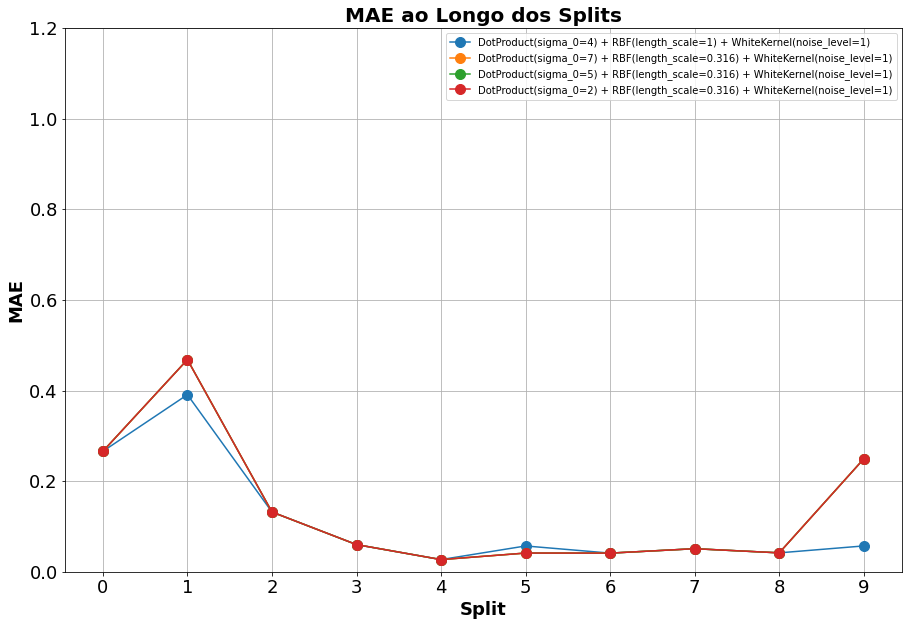

In [90]:
# Gráfico da evolução das métricas - mae
fig, ax = plt.subplots(figsize = (15,10))
for resultado in mae_results:
    ax.plot(splits,mae_results[resultado], marker = '.', markersize = 20, label = resultado)

plt.xticks(splits)  

ax.set_title('MAE ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('MAE', fontweight = 'bold', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid()

ax.set_ylim([0, 1.2])
ax.legend()

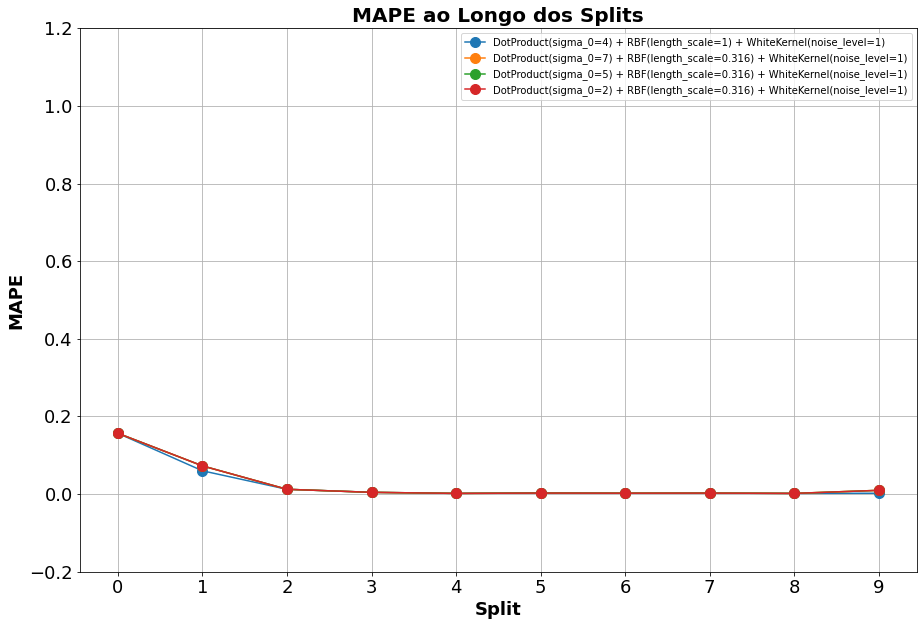

In [91]:
# Gráfico da evolução das métricas - mape
fig, ax = plt.subplots(figsize = (15,10))
for resultado in mape_results:
    ax.plot(splits,mape_results[resultado], marker = '.', markersize = 20, label = resultado)

plt.xticks(splits)  

ax.set_title('MAPE ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('MAPE', fontweight = 'bold', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid()
ax.set_ylim([-0.2, 1.2])
ax.legend()

## Visualização das predições do melhor modelo

In [ ]:
best_model = gsearch.best_estimator_
#Previsões do modelo

CRpred, sigma   = best_model.predict(X, return_std=True)    # previsão para todo o intervalo de dados
CRpred = np.ravel(CRpred)

# Obtendo a variável temporal
t = np.array(df['t'])
t = t.reshape(-1,1)

# Plotando as previsões do melhor modelo

plt.figure(1, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
mpl.style.use('default')
plt.plot(t, y*1000, 'ko', markersize=3, mfc='none', linewidth=1, label=r'Casos acumulados PB')
plt.plot(t, CRpred*1000, 'b-', label='Previsão via modelo GPR', linewidth = 3)


plt.fill(np.concatenate([t, t[::-1]]),
        np.concatenate([CRpred*1000 - 1.9600 * 5000*sigma,
                        (CRpred*1000 + 1.9600 * 5000*sigma)[::-1]]),
        alpha=.25, fc='b', ec='None', label='intervalo de confiança de 95%')
plt.legend(loc='upper left', fontsize = 14)
#plt.ylim(0, 100e3)
#plt.xlim(1, np.size(t) + 20)
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Total de casos', fontsize = 14, fontweight = 'bold')
plt.xlabel('dia', fontsize = 14, fontweight = 'bold')
plt.title('COVID-CG Casos Acumulados', fontsize = 14, fontweight = 'bold')
plt.tick_params(axis='both', which='major', labelsize=18)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

## Visualização dos erros do melhor modelo

In [ ]:
errors = best_model.predict(X) - y
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y.flatten(), y=best_model.predict(X).flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Model  - Test vs Predictions)', xlabel='y', ylabel='y_pred');
ax[1].set(title='Model  - Errors', xlabel='error', ylabel=None);

In [29]:
from prettytable import PrettyTable
def summaryResults(gsearch, modelname, granularity, ranking = True):
    # print(gsearch.cv_results_.keys())
    results = pd.DataFrame(gsearch.cv_results_)
    results.sort_values(by='rank_test_R2', inplace=True)
    results = results.reset_index(drop=True)
    
    t = PrettyTable()
    t.field_names = ["Item","Valor"]
    t.add_row(["Maior R2",np.max(results['mean_test_R2'])])
    t.add_row(["Menor R2",np.min(results['mean_test_R2'])])
    t.add_row(["Std R2", np.std(results['mean_test_R2'])])
    t.add_row(["Melhor MSE:", np.max(results['mean_test_mse'])])
    t.add_row(["Quantidade de modelos: ",len(results)])
    print(t.get_string(title="Summary for " + modelname + " @ " + granularity))
    
    t = PrettyTable()
    t.field_names = ["Ranking", "Parametros","R2-mean","R2-std", "MSE-mean", "MSE-std", "MAE-mean", "MAE-sts", "MAPE-mean", "MAPE-std"]
    names = ['params', 'mean_test_R2', 'std_test_R2','mean_test_mse', 'std_test_mse','mean_test_mae', 'std_test_mae', 'mean_test_mape', 'std_test_mape']
    t._max_width = {"Parametros":1}
    
    if not ranking:
        end = 1
    else:
        end = 3
    
    for i in range(0,end):
        lista = [i + 1]
        for n in names:
            lista.append(results.loc[i,n])
        t.add_row(lista)

    print(t.get_string(title="Top-3 " + modelname + " for " + granularity))
    
    t = PrettyTable()
    fields = []
    values = []
    for i in range(0,5):
        fname = 'split' + str(i)+'_test_R2'
        fields.append(fname)
        values.append(results.loc[0,fname])
        
    t.field_names = fields
    t.add_row(values)
    print(t)

In [30]:
summaryResults(gsearch, 'gpr', 'cg')

+------------------------------------------------+
|              Summary for gpr @ cg              |
+-------------------------+----------------------+
|           Item          |        Valor         |
+-------------------------+----------------------+
|         Maior R2        |  0.9652681089265378  |
|         Menor R2        | -0.22433355316383397 |
|          Std R2         |  0.4846427719254113  |
|       Melhor MSE:       | -0.24965617473427132 |
| Quantidade de modelos:  |          48          |
+-------------------------+----------------------+
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                             Top-3 gpr for cg                                                                                             |
+---------+------------+-----